
## WeatherPy - Josh Bode

In this example, you'll be creating a Python script to visualize the weather of 500+ cities across the world of varying distance from the equator. To accomplish this, you'll be utilizing a [simple Python library](https://pypi.python.org/pypi/citipy), the [OpenWeatherMap API](https://openweathermap.org/api), and a little common sense to create a representative model of weather across world cities.

Your objective is to build a series of scatter plots to showcase the following relationships:

* Temperature (F) vs. Latitude
* Humidity (%) vs. Latitude
* Cloudiness (%) vs. Latitude
* Wind Speed (mph) vs. Latitude

Your final notebook must:

* Randomly select **at least** 500 unique (non-repeat) cities based on latitude and longitude.
* Perform a weather check on each of the cities using a series of successive API calls. 
* Include a print log of each city as it's being processed with the city number, city name, and requested URL.
* Save both a CSV of all data retrieved and png images for each scatter plot.

As final considerations:

* You must use the Matplotlib and Seaborn libraries.
* You must include a written description of three observable trends based on the data. 
* You must use proper labeling of your plots, including aspects like: Plot Titles (with date of analysis) and Axes Labels.
* You must include an exported markdown version of your Notebook called  `README.md` in your GitHub repository.  
* See [Example Solution](WeatherPy_Example.pdf) for a reference on expected format. 


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from citipy import citipy
import matplotlib.pyplot as plt
import apikeys
import requests
import json
import gmaps
from pprint import pprint

plt.style.use('seaborn')

# Configure gmaps
gmaps.configure(api_key=apikeys.gmap_key)

## Generate cities list

### Randomly sample latitude and longitudes

In [2]:
# RANDOMLY SAMPLE LATITDE AND LONGITUDE COMBINATIONS 
#longitude ranges from -180 to + 180
#Latitude ranges from -90 to 90
np.random.seed(777)
long = np.random.uniform(0, 1, 1000)*360-180
lat =  np.random.uniform(0, 1, 1000)*180-90

lat = lat.tolist()
long = long.tolist()

data_dict = {
    "Latitude": lat, 
    "Longitude": long 
}

data = pd.DataFrame(data_dict)
print(data.describe())
data.head()

          Latitude    Longitude
count  1000.000000  1000.000000
mean     -1.091046    -4.015971
std      51.481444   102.557991
min     -89.942776  -179.568845
25%     -45.314472   -95.403158
50%      -0.673413     3.186494
75%      43.799891    82.200252
max      89.724395   179.841436


,Latitude,Longitude
0,-34.962097,-125.041055
1,26.770223,-71.151621
2,-16.054196,-157.666891
3,-50.932404,-14.450277
4,-81.598183,120.691218


### Find city nearest to each latitude and longitude combination

In [3]:
#Find nearest city
for index, row in data.iterrows():
    city =citipy.nearest_city(row['Latitude'], row['Longitude'])
    data.loc[index, "City"] =f'{city.city_name}, {city.country_code}' 
    
#Check for duplicates
data['dups'] = data.duplicated()
data.dups.value_counts()
del data['dups']

#Show the data
data.head()

,Latitude,Longitude,City
0,-34.962097,-125.041055,"rikitea, pf"
1,26.770223,-71.151621,"cockburn town, bs"
2,-16.054196,-157.666891,"avarua, ck"
3,-50.932404,-14.450277,"jamestown, sh"
4,-81.598183,120.691218,"albany, au"


### Replace initial lat/long with actual city lat/long - Use Google GeoLocation

In [4]:
#Replace intial lat/long with city actual lat/long

#Google Geolocation API
target_url = "https://maps.googleapis.com/maps/api/geocode/json"

# Iterate over each row
for index, row in data.iterrows():

    #Update parameters for call
    qparams = {
        'address': row['City'],
        'key': apikeys.gmap_key
    }

    # Request geo location of City
    geo_data = requests.get(target_url, params=qparams).json()
    
    #Replace lat/long in row with the corresponding Dictionary contents
    try:
        lat = geo_data["results"][0]["geometry"]["location"]["lat"]
        lng = geo_data["results"][0]["geometry"]["location"]["lng"]
        data.loc[index, 'Latitude'] = lat
        data.loc[index, 'Longitude'] = lng
    except:
        print(f'City not found')
        

data.head()

City not found
City not found
City not found
City not found
City not found
City not found
City not found
City not found
City not found


,Latitude,Longitude,City
0,-23.119901,-134.970265,"rikitea, pf"
1,24.052744,-74.530216,"cockburn town, bs"
2,-21.212901,-159.782306,"avarua, ck"
3,-15.928634,-5.715175,"jamestown, sh"
4,-35.027530,117.883959,"albany, au"


## Perform Weather API calls

In [6]:
url = "http://api.openweathermap.org/data/2.5/weather"


# query_params = {
#     'appid': apikeys.weather_key,
#     'q': 'boulder, colorado',
#     'units' : 'imperial'
# }
# response = requests.get(url, params=query_params).json()
# #pprint(response)
# clouds = response['clouds']['all']
# print(f'Cloudiness: {clouds}')

for index, row in data.iterrows():
    query_params = {
        'appid': apikeys.weather_key,
        'q': row['City'],
        'units' : 'imperial'
    }
    
    try:             
        response = requests.get(url, params=query_params).json()
        data.loc[index, "Max Temperature"] = response['main']['temp_max']
        data.loc[index, "Min Temperature"] = response['main']['temp_min']
        data.loc[index, "Temperature"] = response['main']['temp']
        data.loc[index, "Humidity"] = response['main']['humidity']
        data.loc[index, "Cloudiness"] = response['clouds']['all']
        data.loc[index, "Wind Speed"] = response['wind']['speed']
        print(str(index) + " " + row['City'] + " url:" + url+ "?" + "q=" +query_params['q'])

    except:
        print('Failed to retrieve weather')
        

0 rikitea, pf url:http://api.openweathermap.org/data/2.5/weather?q=rikitea, pf
1 cockburn town, bs url:http://api.openweathermap.org/data/2.5/weather?q=cockburn town, bs
2 avarua, ck url:http://api.openweathermap.org/data/2.5/weather?q=avarua, ck
3 jamestown, sh url:http://api.openweathermap.org/data/2.5/weather?q=jamestown, sh
4 albany, au url:http://api.openweathermap.org/data/2.5/weather?q=albany, au
5 hobart, au url:http://api.openweathermap.org/data/2.5/weather?q=hobart, au
6 dikson, ru url:http://api.openweathermap.org/data/2.5/weather?q=dikson, ru
Failed to retrieve weather
8 lebu, cl url:http://api.openweathermap.org/data/2.5/weather?q=lebu, cl
Failed to retrieve weather
10 kodiak, us url:http://api.openweathermap.org/data/2.5/weather?q=kodiak, us
11 hilo, us url:http://api.openweathermap.org/data/2.5/weather?q=hilo, us
12 chipinge, zw url:http://api.openweathermap.org/data/2.5/weather?q=chipinge, zw
13 saint-pierre, pm url:http://api.openweathermap.org/data/2.5/weather?q=saint

108 punta arenas, cl url:http://api.openweathermap.org/data/2.5/weather?q=punta arenas, cl
109 hithadhoo, mv url:http://api.openweathermap.org/data/2.5/weather?q=hithadhoo, mv
110 cayenne, gf url:http://api.openweathermap.org/data/2.5/weather?q=cayenne, gf
111 gravdal, no url:http://api.openweathermap.org/data/2.5/weather?q=gravdal, no
Failed to retrieve weather
113 torbay, ca url:http://api.openweathermap.org/data/2.5/weather?q=torbay, ca
114 bikapur, in url:http://api.openweathermap.org/data/2.5/weather?q=bikapur, in
115 chuy, uy url:http://api.openweathermap.org/data/2.5/weather?q=chuy, uy
116 atuona, pf url:http://api.openweathermap.org/data/2.5/weather?q=atuona, pf
Failed to retrieve weather
118 sorland, no url:http://api.openweathermap.org/data/2.5/weather?q=sorland, no
Failed to retrieve weather
120 new norfolk, au url:http://api.openweathermap.org/data/2.5/weather?q=new norfolk, au
121 hermanus, za url:http://api.openweathermap.org/data/2.5/weather?q=hermanus, za
122 port alfre

220 thompson, ca url:http://api.openweathermap.org/data/2.5/weather?q=thompson, ca
221 cap malheureux, mu url:http://api.openweathermap.org/data/2.5/weather?q=cap malheureux, mu
222 nanortalik, gl url:http://api.openweathermap.org/data/2.5/weather?q=nanortalik, gl
223 bredasdorp, za url:http://api.openweathermap.org/data/2.5/weather?q=bredasdorp, za
224 atuona, pf url:http://api.openweathermap.org/data/2.5/weather?q=atuona, pf
225 lebu, cl url:http://api.openweathermap.org/data/2.5/weather?q=lebu, cl
Failed to retrieve weather
227 bethel, us url:http://api.openweathermap.org/data/2.5/weather?q=bethel, us
228 san patricio, mx url:http://api.openweathermap.org/data/2.5/weather?q=san patricio, mx
229 coahuayana, mx url:http://api.openweathermap.org/data/2.5/weather?q=coahuayana, mx
230 tiksi, ru url:http://api.openweathermap.org/data/2.5/weather?q=tiksi, ru
231 ribeira grande, pt url:http://api.openweathermap.org/data/2.5/weather?q=ribeira grande, pt
232 san juan, ar url:http://api.openwe

327 pozo colorado, py url:http://api.openweathermap.org/data/2.5/weather?q=pozo colorado, py
328 tuktoyaktuk, ca url:http://api.openweathermap.org/data/2.5/weather?q=tuktoyaktuk, ca
329 turbat, pk url:http://api.openweathermap.org/data/2.5/weather?q=turbat, pk
Failed to retrieve weather
331 hobart, au url:http://api.openweathermap.org/data/2.5/weather?q=hobart, au
332 yellowknife, ca url:http://api.openweathermap.org/data/2.5/weather?q=yellowknife, ca
333 rikitea, pf url:http://api.openweathermap.org/data/2.5/weather?q=rikitea, pf
334 albany, au url:http://api.openweathermap.org/data/2.5/weather?q=albany, au
335 ribeira grande, pt url:http://api.openweathermap.org/data/2.5/weather?q=ribeira grande, pt
336 busselton, au url:http://api.openweathermap.org/data/2.5/weather?q=busselton, au
Failed to retrieve weather
338 mae sai, th url:http://api.openweathermap.org/data/2.5/weather?q=mae sai, th
339 flinders, au url:http://api.openweathermap.org/data/2.5/weather?q=flinders, au
340 mugur-aks

Failed to retrieve weather
436 college, us url:http://api.openweathermap.org/data/2.5/weather?q=college, us
437 busselton, au url:http://api.openweathermap.org/data/2.5/weather?q=busselton, au
438 bathsheba, bb url:http://api.openweathermap.org/data/2.5/weather?q=bathsheba, bb
439 songea, tz url:http://api.openweathermap.org/data/2.5/weather?q=songea, tz
Failed to retrieve weather
441 tsumeb, na url:http://api.openweathermap.org/data/2.5/weather?q=tsumeb, na
442 aykhal, ru url:http://api.openweathermap.org/data/2.5/weather?q=aykhal, ru
443 rikitea, pf url:http://api.openweathermap.org/data/2.5/weather?q=rikitea, pf
444 bethel, us url:http://api.openweathermap.org/data/2.5/weather?q=bethel, us
445 krabi, th url:http://api.openweathermap.org/data/2.5/weather?q=krabi, th
446 pangnirtung, ca url:http://api.openweathermap.org/data/2.5/weather?q=pangnirtung, ca
447 thanh hoa, vn url:http://api.openweathermap.org/data/2.5/weather?q=thanh hoa, vn
448 puerto ayora, ec url:http://api.openweather

542 clyde river, ca url:http://api.openweathermap.org/data/2.5/weather?q=clyde river, ca
543 bondo, cd url:http://api.openweathermap.org/data/2.5/weather?q=bondo, cd
544 kodiak, us url:http://api.openweathermap.org/data/2.5/weather?q=kodiak, us
545 hami, cn url:http://api.openweathermap.org/data/2.5/weather?q=hami, cn
546 rikitea, pf url:http://api.openweathermap.org/data/2.5/weather?q=rikitea, pf
547 bafoulabe, ml url:http://api.openweathermap.org/data/2.5/weather?q=bafoulabe, ml
548 gejiu, cn url:http://api.openweathermap.org/data/2.5/weather?q=gejiu, cn
549 rohatyn, ua url:http://api.openweathermap.org/data/2.5/weather?q=rohatyn, ua
550 butaritari, ki url:http://api.openweathermap.org/data/2.5/weather?q=butaritari, ki
Failed to retrieve weather
552 dikson, ru url:http://api.openweathermap.org/data/2.5/weather?q=dikson, ru
Failed to retrieve weather
554 atuona, pf url:http://api.openweathermap.org/data/2.5/weather?q=atuona, pf
555 havoysund, no url:http://api.openweathermap.org/data/

650 ushuaia, ar url:http://api.openweathermap.org/data/2.5/weather?q=ushuaia, ar
651 ribeira grande, pt url:http://api.openweathermap.org/data/2.5/weather?q=ribeira grande, pt
652 tilichiki, ru url:http://api.openweathermap.org/data/2.5/weather?q=tilichiki, ru
653 port alfred, za url:http://api.openweathermap.org/data/2.5/weather?q=port alfred, za
654 carnarvon, au url:http://api.openweathermap.org/data/2.5/weather?q=carnarvon, au
655 nome, us url:http://api.openweathermap.org/data/2.5/weather?q=nome, us
656 mahebourg, mu url:http://api.openweathermap.org/data/2.5/weather?q=mahebourg, mu
657 nuuk, gl url:http://api.openweathermap.org/data/2.5/weather?q=nuuk, gl
658 te anau, nz url:http://api.openweathermap.org/data/2.5/weather?q=te anau, nz
659 coquimbo, cl url:http://api.openweathermap.org/data/2.5/weather?q=coquimbo, cl
Failed to retrieve weather
661 komsomolskiy, ru url:http://api.openweathermap.org/data/2.5/weather?q=komsomolskiy, ru
662 iqaluit, ca url:http://api.openweathermap.or

758 kiunga, pg url:http://api.openweathermap.org/data/2.5/weather?q=kiunga, pg
759 lebu, cl url:http://api.openweathermap.org/data/2.5/weather?q=lebu, cl
760 ushuaia, ar url:http://api.openweathermap.org/data/2.5/weather?q=ushuaia, ar
761 pevek, ru url:http://api.openweathermap.org/data/2.5/weather?q=pevek, ru
762 coihaique, cl url:http://api.openweathermap.org/data/2.5/weather?q=coihaique, cl
763 kapaa, us url:http://api.openweathermap.org/data/2.5/weather?q=kapaa, us
764 busselton, au url:http://api.openweathermap.org/data/2.5/weather?q=busselton, au
765 katsuura, jp url:http://api.openweathermap.org/data/2.5/weather?q=katsuura, jp
766 albany, au url:http://api.openweathermap.org/data/2.5/weather?q=albany, au
Failed to retrieve weather
768 albany, au url:http://api.openweathermap.org/data/2.5/weather?q=albany, au
Failed to retrieve weather
770 puerto ayora, ec url:http://api.openweathermap.org/data/2.5/weather?q=puerto ayora, ec
771 acapulco, mx url:http://api.openweathermap.org/data

861 mahebourg, mu url:http://api.openweathermap.org/data/2.5/weather?q=mahebourg, mu
862 langenlois, at url:http://api.openweathermap.org/data/2.5/weather?q=langenlois, at
863 busselton, au url:http://api.openweathermap.org/data/2.5/weather?q=busselton, au
864 port elizabeth, za url:http://api.openweathermap.org/data/2.5/weather?q=port elizabeth, za
865 yellowknife, ca url:http://api.openweathermap.org/data/2.5/weather?q=yellowknife, ca
866 kapaa, us url:http://api.openweathermap.org/data/2.5/weather?q=kapaa, us
867 bredasdorp, za url:http://api.openweathermap.org/data/2.5/weather?q=bredasdorp, za
868 cherskiy, ru url:http://api.openweathermap.org/data/2.5/weather?q=cherskiy, ru
869 magnitogorsk, ru url:http://api.openweathermap.org/data/2.5/weather?q=magnitogorsk, ru
870 rikitea, pf url:http://api.openweathermap.org/data/2.5/weather?q=rikitea, pf
871 ushuaia, ar url:http://api.openweathermap.org/data/2.5/weather?q=ushuaia, ar
872 bluff, nz url:http://api.openweathermap.org/data/2.5/we

970 sorland, no url:http://api.openweathermap.org/data/2.5/weather?q=sorland, no
971 hermanus, za url:http://api.openweathermap.org/data/2.5/weather?q=hermanus, za
972 port moresby, pg url:http://api.openweathermap.org/data/2.5/weather?q=port moresby, pg
973 tasiilaq, gl url:http://api.openweathermap.org/data/2.5/weather?q=tasiilaq, gl
974 jamestown, sh url:http://api.openweathermap.org/data/2.5/weather?q=jamestown, sh
975 buta, cd url:http://api.openweathermap.org/data/2.5/weather?q=buta, cd
Failed to retrieve weather
977 cairns, au url:http://api.openweathermap.org/data/2.5/weather?q=cairns, au
978 hermanus, za url:http://api.openweathermap.org/data/2.5/weather?q=hermanus, za
979 new norfolk, au url:http://api.openweathermap.org/data/2.5/weather?q=new norfolk, au
980 ushuaia, ar url:http://api.openweathermap.org/data/2.5/weather?q=ushuaia, ar
981 meulaboh, id url:http://api.openweathermap.org/data/2.5/weather?q=meulaboh, id
982 ushuaia, ar url:http://api.openweathermap.org/data/2.5/w

In [8]:
# Remove cities without temperature or lat long info
data.dropna(how = 'any', inplace=True)

#Remove duplicates - Results cluster around islands and coastal towns
data.drop_duplicates(inplace = True)

#Summarize
print(data.describe())
data.head()

         Latitude   Longitude  Max Temperature  Min Temperature  Temperature  \
count  512.000000  512.000000       512.000000       512.000000   512.000000   
mean    18.586666   15.211904        65.169102        64.722617    64.955020   
std     36.375035   94.680362        15.370667        15.191007    15.256723   
min    -54.801912 -179.118379        29.690000        29.690000    29.690000   
25%    -14.011623  -65.896235        53.810000        53.600000    53.810000   
50%     19.926619   18.561636        68.000000        67.970000    68.000000   
75%     50.719591   97.519958        78.380000        77.412500    78.155000   
max     85.724731  179.355123        95.000000        93.200000    93.200000   

         Humidity  Cloudiness  Wind Speed  
count  512.000000  512.000000  512.000000  
mean    76.125000   38.531250    8.015859  
std     22.178073   35.295163    5.457859  
min     12.000000    0.000000    0.740000  
25%     63.000000    1.000000    3.760000  
50%     81.0000

,Latitude,Longitude,City,Max Temperature,Min Temperature,Temperature,Humidity,Cloudiness,Wind Speed,dups
0,-23.119901,-134.970265,"rikitea, pf",76.04,76.04,76.04,100.0,76.0,23.67,False
1,24.052744,-74.530216,"cockburn town, bs",80.54,80.54,80.54,100.0,0.0,6.55,False
2,-21.212901,-159.782306,"avarua, ck",78.80,78.80,78.80,74.0,20.0,8.05,False
3,-15.928634,-5.715175,"jamestown, sh",70.19,70.19,70.19,100.0,24.0,12.26,False
4,-35.027530,117.883959,"albany, au",61.28,61.28,61.28,53.0,0.0,17.85,False


## Latitude versus Temperature Plot

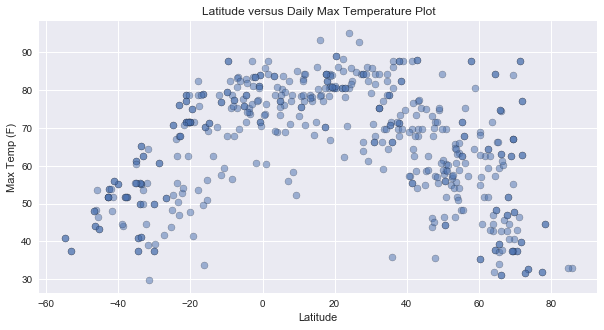

In [9]:
#Due to differences in time of day across cities, I used the maximum daily temperature.
plt.figure(figsize=(10,5))
plt.scatter(data['Latitude'], data['Max Temperature'], alpha=0.5, edgecolors= 'black')
plt.xlabel("Latitude")
plt.ylabel("Max Temp (F)")
plt.title("Latitude versus Daily Max Temperature Plot")
plt.show()

### Heatmap of Latitude versus  Max Temperature 


In [10]:
#Create location lat/long combos
locations = data[["Latitude", "Longitude"]]

#Options
scale =  round(1 +  ((data['Max Temperature'] -32 )*5/9)**0.75, 1) 

#Info Box content - Iterate through row, create string and append to pop up list

popup_list = []

for index, row in data.iterrows():
    popup = f"City: {row['City']}<br>\n" \
            f"Latitude: {row['Latitude']:.6f}<br>\n" \
            f"Longitude: {row['Longitude']:.6f}<br>\n" \
            f"Max Temp(F): {row['Max Temperature']:.1f}"

    popup_list.append(popup) 

# Plot Base map
fig = gmaps.figure(map_type="TERRAIN", zoom_level =2, center=(0, -80))


# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=scale, 
                                 dissipating=False, max_intensity=10,
                                 point_radius=5, opacity = 0.4)      

#Create symbol layer (with hover and popups)
symbol_layer = gmaps.symbol_layer(
    locations, fill_color = 'rgba(0, 152, 215, 0.5)',
    stroke_color = 'rgba(0, 152, 215, 0.5)',
    scale = 2, 
    info_box_content = popup_list
)

#Add layers
fig.add_layer(heat_layer)
fig.add_layer(symbol_layer)
                                                        
# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

## Latitude versus Humidity Plot

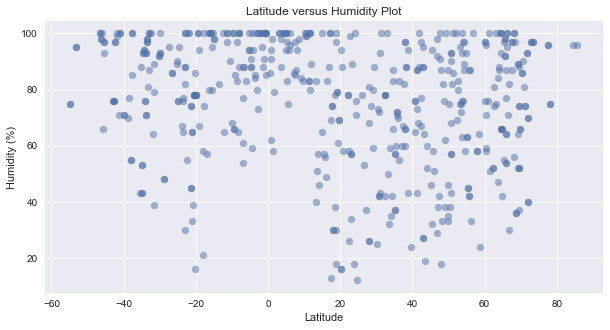

In [11]:
#Due to differences in time of day across cities, I used the maximum daily temperature.
plt.figure(figsize=(10,5))
plt.scatter(data['Latitude'], data['Humidity'], alpha=0.5, edgecolors='grey')
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title("Latitude versus Humidity Plot")
plt.show()

## Latitude versus Cloudiness Plot

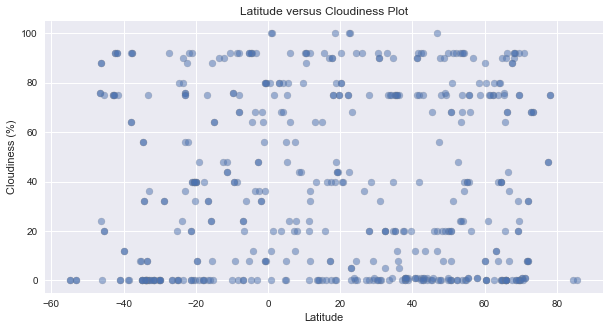

In [12]:
data.head()

#Due to differences in time of day across cities, I used the maximum daily temperature.
plt.figure(figsize=(10,5))
plt.scatter(data['Latitude'], data['Cloudiness'], alpha=0.5, edgecolors='grey')
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title("Latitude versus Cloudiness Plot")
plt.show()


## Latitude versus Wind Speed Plot

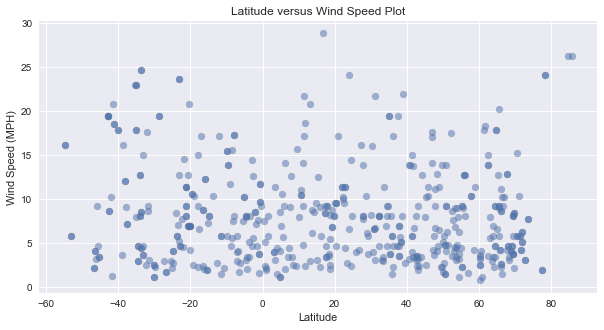

In [13]:
#Wind Speed.
plt.figure(figsize=(10,5))
plt.scatter(data['Latitude'], data['Wind Speed'], alpha=0.5, edgecolors='grey')
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (MPH)")
plt.title("Latitude versus Wind Speed Plot")
plt.show()

## Conclusions

We compared a number of metrics - temperature, humidity, cloudiness, wind speed - against latitude. The approach relied on random draws of latitude and longitude and finding the nearest city and the temperature for that city. Key finding are:

* Despite randomly drawning lat/long values, the nearest cities clustered around islands and coastlines because so much of the world is covered by water. A large share of them were duplicates and were removed.

* There is a clear relationship between latitude and temperature. The closer you are to the equator, the hotter it is. The hottest point is not currently at the equator, but at around 10 degrees Norht of it. This is likely due to the tilt of the Earth when the data was drawn.

* The relationship between latitude and humidity, cloudiness, and wind speed, if any, is weak. 